<a href="https://colab.research.google.com/github/jeaneigsi/CapitalMind/blob/main/storydiffusionllm_(lab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade diffusers transformers accelerate mediapy peft
!pip install huggingface_hub langchain langchain_core langchain_community
!pip install Pillow
!!pip install GPUtil
!pip install rembg

In [2]:
import os
import mediapy as media
import random
import sys
import torch
import matplotlib.pyplot as plt
from rembg import remove


In [3]:
from typing import List
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from getpass import getpass
from langchain_community.llms import HuggingFaceEndpoint
from langchain.chains import LLMChain
from diffusers import DiffusionPipeline, TCDScheduler
from huggingface_hub import hf_hub_download
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
# set hf inference endpoint with lama for story
# get a token: https://huggingface.co/docs/api-inference/quicktour#get-your-api-token


HUGGINGFACEHUB_API_TOKEN = getpass()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

··········


In [52]:
# Define your desired data structure.
class Story(BaseModel):
    title:str=Field(description="A captivating title for history")
    characters: List[str]=Field(description= "Important : A list that contains six elements. Each item on the list is made up of the name of a character in the story and a description of their appearance. The description contains only separate ajectives after a comma which describes in detail the character's appenre with the addition of the words cartoon,style africa, painting")
    scenes: List[str]= Field(description="Important : A list that contains six elements. Each item in the list is composed of a scene from the story that corresponds to a frame. It is structured in the form [name of the character],[action of the character],[description with only adjectives of the place and present elements].")
    metadonne: List[str] = Field("Important : A list that contains six elements. Each item in the list consists of a description of the associated scene element. It can be either a narrative commentary on the scene, or a character dialogue. This field should only explain the scene for the readers to understand the story")


In [28]:

repo_id = "meta-llama/Meta-Llama-3-8B-Instruct"
question = "Who won the FIFA World Cup in the year 1994? "
template = """Question: {question}

Answer: Let's think step by step."""

prompt = PromptTemplate.from_template(template)
llm = HuggingFaceEndpoint(
    repo_id=repo_id, max_length=400, temperature=0.7, token=HUGGINGFACEHUB_API_TOKEN
)
llm_chain = LLMChain(prompt=prompt, llm=llm)
print(llm_chain.run(question))

model=llm

                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.
                    token was transferred to model_kwargs.
                    Please make sure that token is what you intended.


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
 The FIFA World Cup was held in 1994. The team that won the tournament was the Brazil national football team. So, the answer is Brazil. They won the tournament by defeating Italy 3-2 in a penalty shootout after the game had ended 0-0 after extra time. The final was played at the Rose Bowl in Pasadena, California, United States. So, Brazil won the FIFA World Cup in 1994.


In [53]:
system="You are an expert in creating stories about the educational African people. Your objective is to make the proposal of African culture through your little stories. Each story has only 3 characters but you stage them in a great way to create the best one. history. very important: add a the end of each charcters description these word : backgroung aquarelle, painting benin style, mugshot. Your story must always be about legends of African and kingdoms"

In [54]:
story_query=system+"Generate a super hero comis with evil endings"
parser = PydanticOutputParser(pydantic_object=Story)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | model | parser

chain.invoke({"query": story_query})

Story(title='The Legend of the Golden Lion', characters=['Kofi, the brave warrior, with a strong and muscular body, sharp eyes and a fierce determination, background aquarelle, painting Benin style, mugshot', 'Queen Akua, the wise and just ruler, with a calm and composed demeanor, a gentle smile and a kind heart, background aquarelle, painting Benin style, mugshot', 'Jaguar, the dark sorcerer, with a twisted and evil grin, a wicked cackle and a sinister presence, background aquarelle, painting Benin style, mugshot'], scenes=['Kofi, the brave warrior, enters the kingdom, seeking to defend Queen Akua from the evil sorcerer Jaguar', 'Queen Akua, the wise and just ruler, welcomes Kofi and thanks him for his bravery', "Jaguar, the dark sorcerer, casts a spell to turn the kingdom's crops into dust", 'Kofi, the brave warrior, battles Jaguar and defeats him, saving the kingdom', 'Queen Akua, the wise and just ruler, thanks Kofi and rewards him with a golden lion medal', "The kingdom celebrates

In [55]:
response =chain.invoke({"query": story_query})
response


Story(title='The Legend of the Golden Lion', characters=['Kofi, the brave warrior, with a strong and muscular body, sharp eyes and a fierce determination, background aquarelle, painting Benin style, mugshot', 'Queen Akua, the wise and just ruler, with a calm and composed demeanor, a gentle smile and a kind heart, background aquarelle, painting Benin style, mugshot', 'Jaguar, the dark sorcerer, with a twisted and evil grin, a wicked cackle and a sinister presence, background aquarelle, painting Benin style, mugshot'], scenes=['Kofi, the brave warrior, enters the kingdom, seeking to defend Queen Akua from the evil sorcerer Jaguar', 'Queen Akua, the wise and just ruler, welcomes Kofi and thanks him for his bravery', "Jaguar, the dark sorcerer, casts a spell to turn the kingdom's crops into dust", 'Kofi, the brave warrior, battles Jaguar and defeats him, saving the kingdom', 'Queen Akua, the wise and just ruler, thanks Kofi and rewards him with a golden lion medal', "The kingdom celebrates

In [35]:
type(response.characters) # recuperer le contenu des champs

list

In [56]:
# Choose among 1, 2, 4 and 8:
num_inference_steps = 6

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "ByteDance/Hyper-SD"
plural = "s" if num_inference_steps > 1 else ""
ckpt_name = f"Hyper-SDXL-{num_inference_steps}step{plural}-lora.safetensors"
device = "cuda"

pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16, variant="fp16")
pipe.load_lora_weights(hf_hub_download(repo_name, ckpt_name))
pipe.fuse_lora()
pipe.enable_sequential_cpu_offload()
pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

EntryNotFoundError: 404 Client Error. (Request ID: Root=1-66439295-7c760e1743904f437fe90012;36b89ab1-2fee-4899-93b4-77e250d7b1df)

Entry Not Found for url: https://huggingface.co/ByteDance/Hyper-SD/resolve/main/Hyper-SDXL-6steps-lora.safetensors.

In [57]:

negative_prompt="photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, sloppy, duplicate, mutated, black and white"
prompt = "Black backgroung aquarelle, painting benin  style, mugshot young girl "
seed = 46
# Decrease eta (min: 0, max: 1.0) to get more details with multi-step inference:
eta = 0.5

images = pipe(
    prompt = prompt,
    num_inference_steps = num_inference_steps,
    guidance_scale = 0.9,
    eta = eta,
    negative_prompt=negative_prompt,
    generator = torch.Generator(device).manual_seed(seed),
    ).images

print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)


RuntimeError: "LayerNormKernelImpl" not implemented for 'Half'

In [12]:

#https://www.kaggle.com/discussions/getting-started/140636
# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()

# free_gpu_cache()

from GPUtil import showUtilization as gpu_usage
gpu_usage()
#torch.cuda.empty_cache()



| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |


In [13]:
images[0].save("output.jpg")

In [14]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Gallery of prompt

### [Link 1](https://letstryai.com/midjourney-prompts-for-cartoon-characters/)


In [39]:
response.scenes
# response.scenes[:4]

['Kofi and Ama, in the throne room, discussing the fate of the kingdom, while Osei sneaks around, trying to steal the Golden Scepter',
 "Osei, in the dark forest, using his cunning to escape from Kofi and Ama's pursuit",
 'Kofi and Ama, in the final showdown, fighting Osei and his minions, to reclaim the Golden Scepter']

In [40]:
num_rows=1

In [48]:

seed=46
prompt = response.scenes

all_images = []
for i in range(num_rows):
  images = pipe(
    prompt=prompt,
    num_inference_steps = num_inference_steps,
    guidance_scale = 0.3,
    eta = eta,
    negative_prompt=negative_prompt,
    generator = torch.Generator(device).manual_seed(seed)).images
  all_images.extend(images)


  0%|          | 0/8 [00:00<?, ?it/s]

In [49]:
all_images

[<PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>]

In [50]:
len(all_images)
num_rows=1
num_cols=3

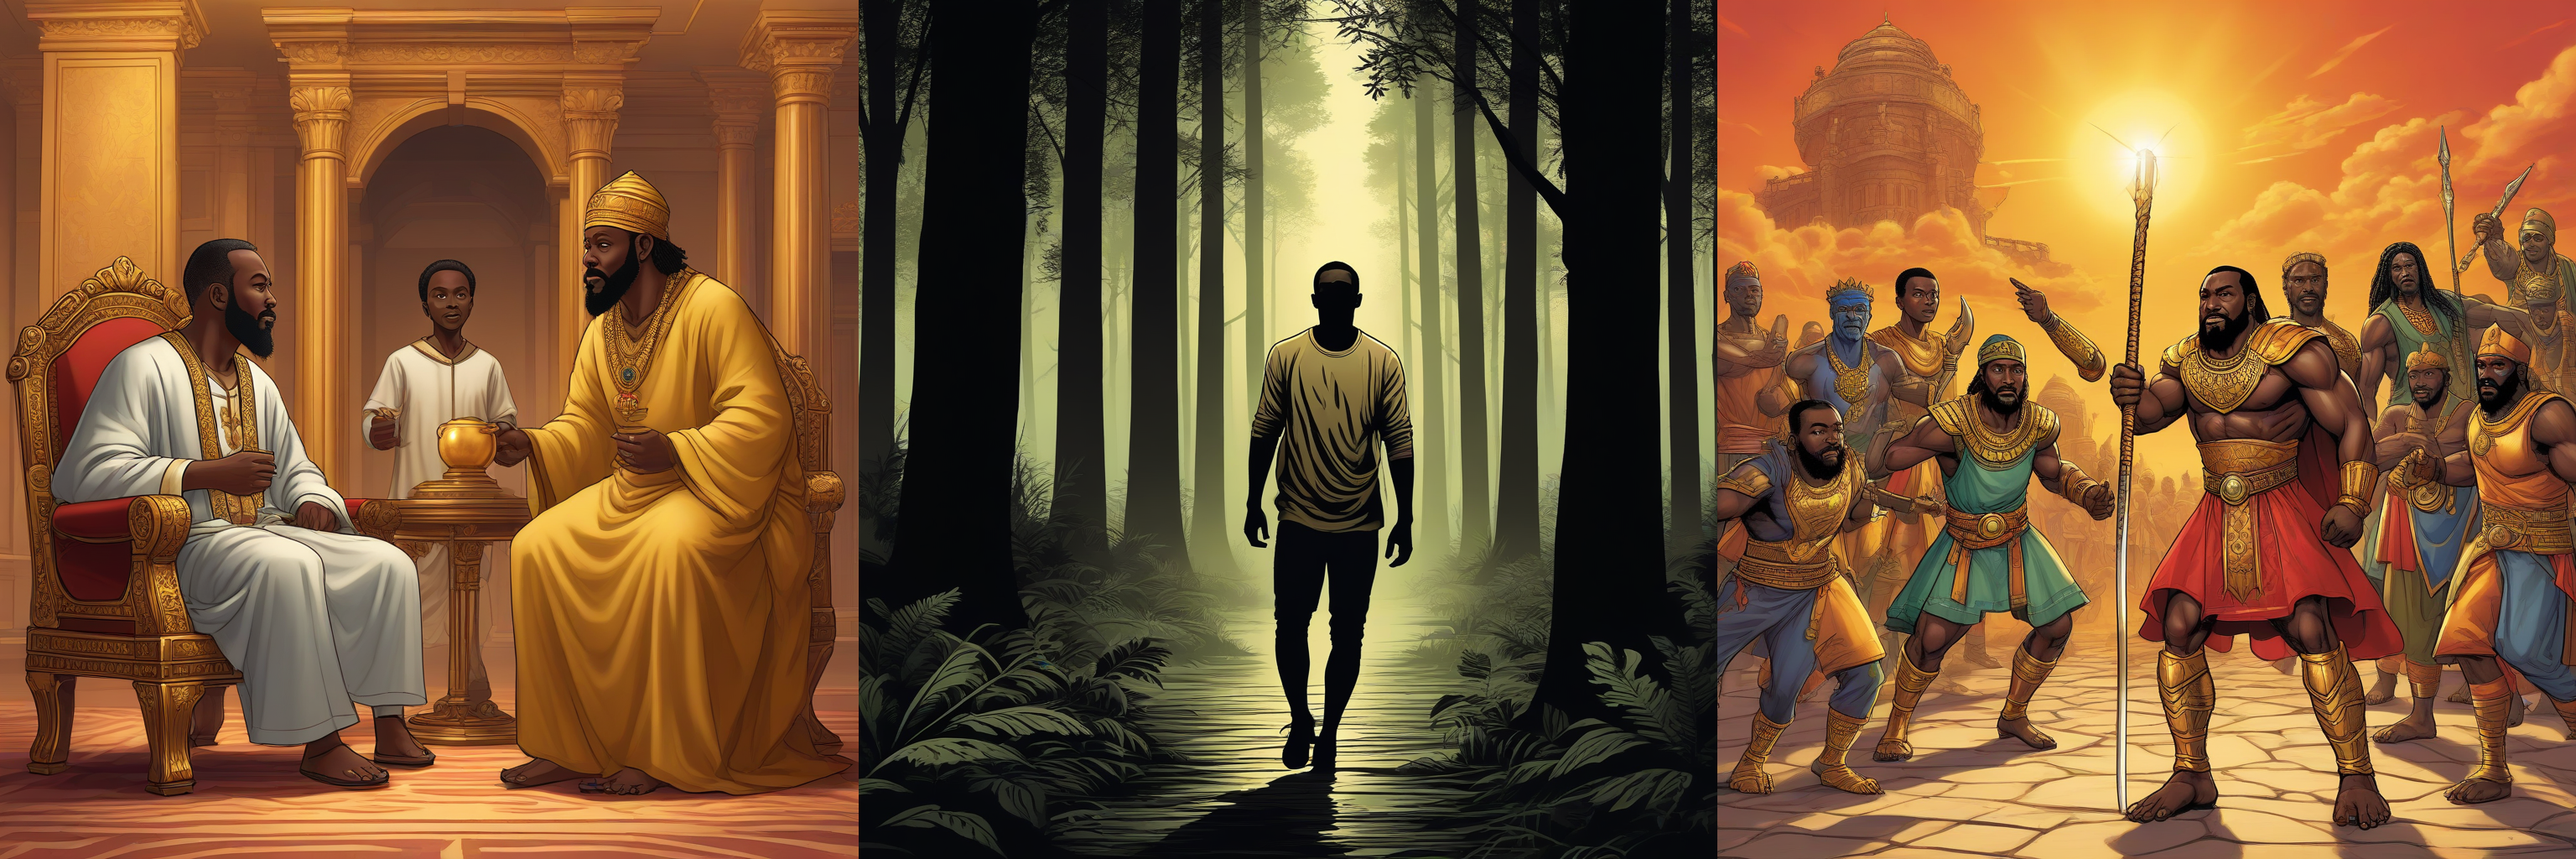

In [51]:
grid = image_grid(all_images,rows=num_rows,cols=num_cols)
grid


In [ ]:

output=remove(images[0])
# output.save()

In [45]:
# describe = ['bien','mal','cool','passable'] List to store image descriptions
describe=response.metadonne


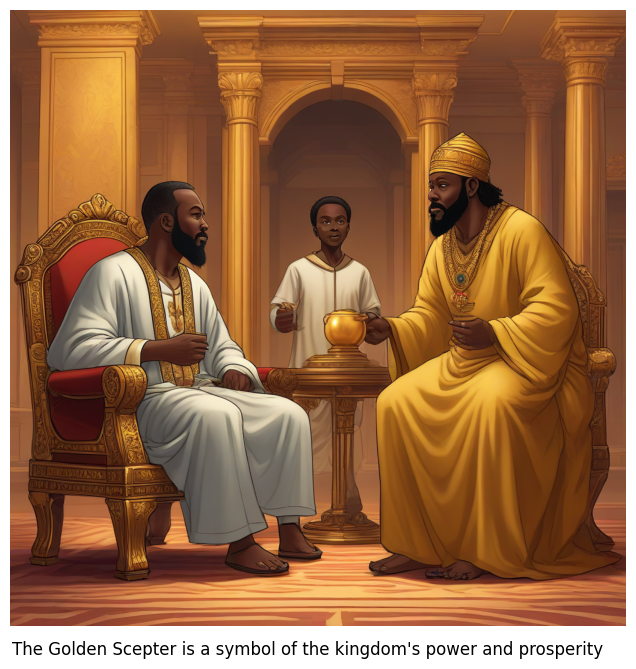

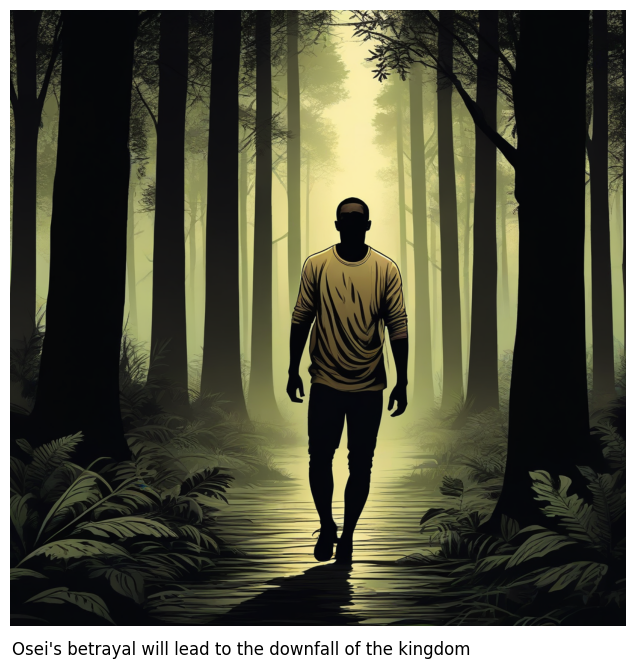

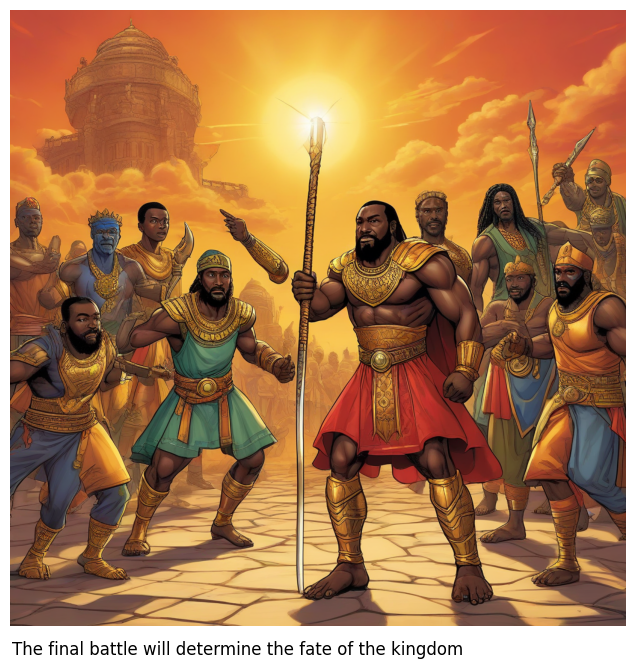

In [46]:
# Function to display image with description as a legend
def display_image_with_description(image, description):
    fig, ax = plt.subplots(figsize=(8, 8))  # Create figure and axes
    ax.imshow(image)
    ax.axis('off')  # Turn off axes
    fig.text(0.13, 0.08, description, ha='left', va='center', fontsize=12)  # Add description as legend
    plt.show()

# Display each image with its description
for i in range(len(all_images)):
    display_image_with_description(all_images[i], describe[i])